# <center>Regularization in Neural Network</center>
<center>Shan-Hung Wu & DataLab<br/>Fall 2016</center>

In [2]:
from IPython.display import Image
from IPython.display import display

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *

Deep neural network with a large number of parameters is a powerful machine learning system, but over-fitting is a serious issues in such networks. Deep neural network contains many non-linear hidden units and thus they can express very complicated relationships between their inputs and outputs. With limited training data, many of these relationships will be the result of sampling noise, so these relationships exist only on the training dataset, but not on the testing dataset. Large networks are slow, so it's hard for us to deal with the over-fitting issues by training several networks with different architecture and combine their outputs.
In this lab, we are going to talk about regularization in neural network.
We will introduce some common regularization methods in deep neural network today, which is 
* Dropout
* Weight decay
* Weight constraint
* Data augmentation

We use the CIFAR-10 dataset for our experiment. [CIFAR-10]() is a object recognition dataset of 10 class. The CIFAR-10 dataset consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 


The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

Here are the classes in the dataset, as well as 10 random images from each:
<img src="fig-cifar-10.png" width="400">



# Loading and Preprocess the CIFAR-10 Dataset

## Load Data
Set the path for storing the dataset on your machine.

In [3]:
import os
import numpy as np
import sys
import tarfile
import urllib.request
import pickle
import _pickle as cPickle
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from os.path import expanduser
home = expanduser('~')
data_path = os.path.join(home, "data/CIFAR-10/")

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5105)


Set the constants for processing the dataset.

In [4]:
# the width and height of thes image
img_size = 32
# number of channels: red, green and blue
img_channels = 3
# number of classes
nb_classes = 10
# the width and height of out image
img_size = 32
# length of the image after we flatten the image into a 1-dim array
img_size_flat = img_size * img_size * img_channels
# number of classes
nb_classes = 10
# number of files in the training dataset
nb_files_train = 5
# number of images for each batch-file in the training-set.
images_per_file = 10000
# number of all the images in the training dataset
nb_images_train = nb_files_train * images_per_file


This is the code for downloading and extracting the cifar dataset from the internet

In [5]:
def download_and_extract_cifar():
    filename = 'cifar-10-batches-py/'
    file_path = os.path.join(data_path, filename)

    # if the file exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # check if the download directory exists, otherwise create it.
        if not os.path.exists(data_path):
            os.makedirs(data_path)

        # download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=data_url,
                                                  filename=os.path.join(data_path, 'cifar-10-python.tar.gz'),
                                                  reporthook=_print_download_progress)
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(data_path)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(data_path)

        print("Done.")
    else:
        print("Data has already been downloaded and unpacked.")

In [6]:
def load_cifar():
    def load_data(file_name):
        """
        Load a pickled data-file from the CIFAR-10 data-set
        and return the converted and the class-number
        for each image.
        """

        file_path = os.path.join(data_path, "cifar-10-batches-py/", file_name)

        print("Loading data: " + file_path)

        with open(file_path, mode='rb') as file:    
            data = pickle.load(file, encoding='bytes')

        raw_images = data[b'data']

        # get the class-numbers for each image. Convert to numpy-array.
        cls = np.array(data[b'labels'])

        # convert the raw images from the data-files to floating-points.
        raw_float = np.array(raw_images, dtype=float) / 255.0

        # reshape the array to a 4-dim array with shape: [image_number, channel, height, width] where the pixels are floats between 0.0 and 1.0.
        images = raw_float.reshape([-1, img_channels, img_size, img_size])

        return images, cls

    def load_training_data():
        """
        Load all the training-data for the CIFAR-10 data-set.
        The data-set is split into 5 data-files which are merged here.
        Returns the images, class-numbers and one-hot encoded class-labels.
        """

        # pre-allocate the arrays for the images and class-numbers for efficiency.
        images = np.zeros(shape=[nb_images_train, img_channels, img_size, img_size], dtype=float)
        cls = np.zeros(shape=[nb_images_train], dtype=int)

        # begin-index for the current batch.
        begin = 0

        for i in range(nb_files_train):

            images_batch, cls_batch = load_data(file_name="data_batch_" + str(i + 1))
            num_images = len(images_batch)

            # End-index for the current batch.
            end = begin + num_images

            # store the images and class-numbers into the array.
            images[begin:end, :] = images_batch
            cls[begin:end] = cls_batch

            # The begin-index for the next batch is the current end-index.
            begin = end

        return images, cls, np_utils.to_categorical(cls, nb_classes)

    def load_test_data():
        """
        Load all the test-data for the CIFAR-10 data-set.
        Returns the images, class-numbers and one-hot encoded class-labels.
        """

        images, cls = load_data(file_name="test_batch")

        return images, cls, np_utils.to_categorical(cls, nb_classes)
    download_and_extract_cifar()
    X_train, cls_train, y_train = load_training_data()
    X_test, cls_test, y_test = load_test_data()

    # split out validation dataset from training dataset
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

Print out the size of the training and testing set to check if everything is loaded correctly.

In [7]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_cifar()

Data has already been downloaded and unpacked.
Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: /home/greyjoy/data/CIFAR-10/cifar-10-batches-py/test_batch


In [9]:
# check data
print("Size of:")
print("- Training-set:\t\t{}".format(len(X_train)))
print("- Validation-set:\t{}".format(len(X_valid)))
print("- Test-set:\t\t{}".format(len(X_test)))

Size of:
- Training-set:		40000
- Validation-set:	10000
- Test-set:		10000


Then we convert the images into grey-scale

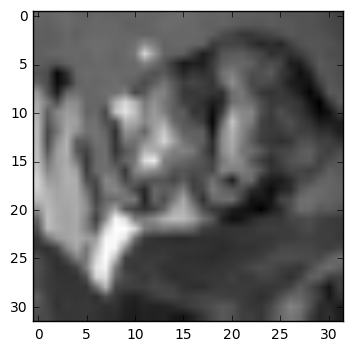

In [10]:
def _grayscale(data, dtype='float32'):
    # we use the luma coding weighted average in video systems here (https://en.wikipedia.org/wiki/Grayscale)
    r, g, b = np.asarray(.3,dtype=dtype), np.asarray(.59,dtype=dtype), np.asarray(.11,dtype=dtype)
    rst = r*data[:,0,:, :] + g*data[:, 1, :, :] + b*data[:, 2, :, :]
    # plot out image
    plt.imshow(rst[0], cmap=plt.get_cmap('gray'))
    # add dummy axis to make single image from size (32, 32) to (1, 32 ,32)
    rst = np.expand_dims(rst, axis=1)
    # return rst.reshape((-1,1,32,32))
    return rst


X_train_grey = _grayscale(X_train)
X_valid_grey = _grayscale(X_valid)
X_test_grey = _grayscale(X_test)
# now we have only one channel in the images
img_channels = 1

In [13]:
print(np.shape(X_train_grey))

(40000, 1, 32, 32)


Let's use a deeper model to deal with the task today.

In [123]:
# here are some settings for the network experiment
batch_size = 32
nb_epoch = 50
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

CPU times: user 1min 27s, sys: 8.07 s, total: 1min 35s
Wall time: 1min 35s
Test loss: 1.843
Test accuracy: 0.374


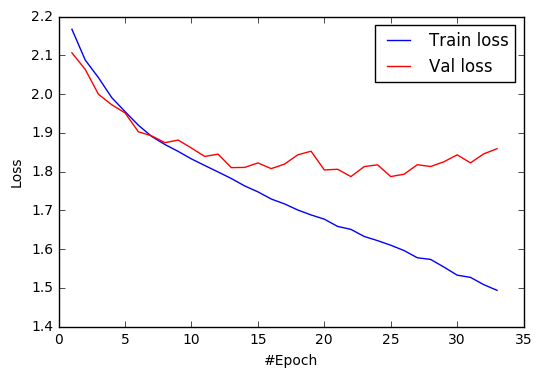

In [81]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.constraints import maxnorm
from keras.regularizers import l1, l2
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import sys
import os
import time

model = Sequential()
# flatten our input into a single dimension array
model.add(Flatten(input_shape=(1, 32, 32)))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))

# output layer
model.add(Dense(nb_classes, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

start = time.time()
%time his = model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=50, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = model.evaluate(X_test_grey, y_test, verbose=0)
# print('\nTraining time: %f sec' % float(time.time()-start))
print('Test loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(his, './output/fig-vanilla-val-baseline.png')

Apparently we are having the issues of over fitting here. It's a chance for us to learn some regularizations technique.

# Dropout
Dropout is designed by Geoffrey Hinton.
The key idea is to randomly drop some units from the neural network during training, so that the neuron have to function well on its own instead of relying on other neurons. (Just like when you know your teammate is not that reliable, you have to take more responsibility)
In a standard neural network, the derivative received by each parameter tells it how it should change so the final loss function is reduced, given what all other units are doing. Therefore, units may change in a way that they fix up the mistakes of the other units. This may lead to complex co-adaptations.
Applying dropout to a neural network amounts to sampling a “thinned” network from it. The thinned network consists of all the units that are not dropped out (Figure b). A neural net with $n$ units, can be seen as a collection of  possible thinned neural networks. For each presentation of each training case, a new thinned network is sampled and trained.

The following figures illustrate the architecture:

<img src="fig-dropout.png" width="600">
<img src="fig-ensemble-of-subnetworks.png" width="600">


The choice of which units to drop is random. In the simplest case, each unit is retained with a fixed probability $p$ independent of other units, where $p$ can be chosen using a validation set or can simply be set at 0.5, which seems to be close to optimal for a wide range of networks and tasks.
At test time, it is not feasible to explicitly average the predictions from exponentially many thinned models. A very simple approximate averaging method works well in practice. The idea is to use a single neural net at test time **without dropout**. If a unit is retained with probability $p$ during training, the outgoing weights of that unit are multiplied by $p$ at test time as shown in the figure below. This is to ensure that for any hidden unit the expected output (under the distribution used to drop units at training time) is the same as the actual output at test time.
<img src="fig-weight.png" width="600">

Let's wrap our code into a function with several kinds of regularization options.

In [114]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GaussianNoise, MaxoutDense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.constraints import maxnorm
from keras.regularizers import l1, l2
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import sys
import os
import time

# monitor the validation loss
# min_delta : minimum change in the monitored quantity to qualify as an improvement
# patience : number of epochs with no improvement after which training will be stopped
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0)

def gen_nn(nb_layers=8, nb_neurons=512, dropout=False, weight_constraint=False, l2_reg=False, l2_coef=0.1, batch_normalization=False, adam=False, learning_rate=0.001, decay=True):
    """
    Create a model according to the specification.
    """
    # here are some settings for the network   
    
    model = Sequential()
    model.add(Flatten(input_shape=(1, 32, 32))) 
    
    for i in (0, nb_layers):
        
        # we can think of this chunk as the hidden layer  
        if l2_reg:
            model.add(Dense(nb_neurons, W_regularizer=l2(l2_coef))) 
        elif weight_constraint:
            model.add(Dense(nb_neurons, W_constraint=maxnorm(3)))            
        else:
            model.add(Dense(nb_neurons))

        if batch_normalization:
            model.add(BatchNormalization(epsilon=0.001, mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one'))
        # add dropout after every two layers with dropout rate 0.25
        if dropout and i%2==0:
            model.add(Dropout(0.25))
            
        model.add(Activation('relu'))
        # end of a hidden layer

        

    model.add(Dense(nb_classes, activation='softmax'))
    # compile model
    if decay:
        decay = learning_rate/nb_epoch
    else:
        decay = 0.0
    if adam:
        adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
        model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    else:
        sgd = SGD(lr=0.01, momentum=0.9, decay=0.01/nb_epoch, nesterov=False)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

CPU times: user 1min, sys: 2.97 s, total: 1min 3s
Wall time: 1min 3s

Test loss: 1.549
Test accuracy: 0.446


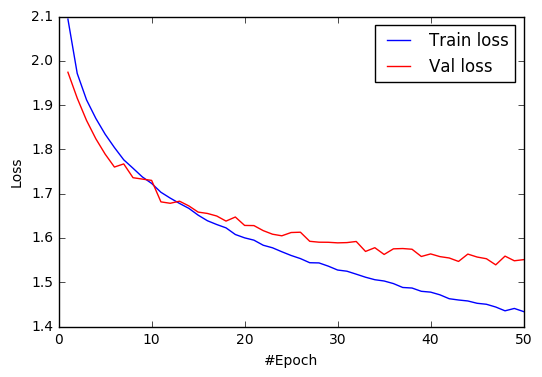

In [47]:
# dropout with decay learning rate SGD
dropout_model = gen_nn(dropout=True, Adam=False)

%time dropout_his = dropout_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = dropout_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(dropout_his , './output/fig-nn-val-dropout.png')

CPU times: user 2min 8s, sys: 5.9 s, total: 2min 14s
Wall time: 2min 14s

Test loss: 1.668
Test accuracy: 0.413


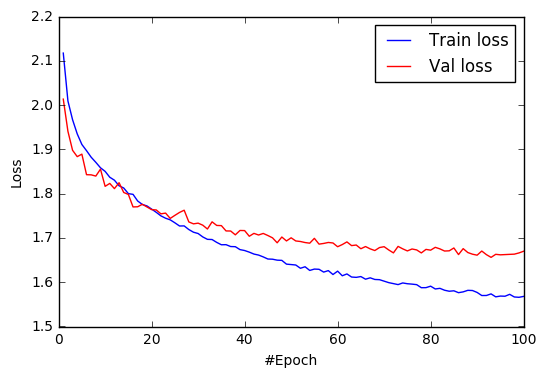

In [90]:
# dropout with decay learning rate Adam
dropout_model = gen_nn(dropout=True, adam=True, learning_rate=0.001)

%time dropout_his = dropout_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = dropout_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(dropout_his , './output/fig-nn-val-dropout-adam.png')

We can see the dropout has a signifanct effect on the result!

# Weight Decay
If you recall we talked about weight decay before. We can penalize large weights using penalties or constraints on their squared values (L2 penalty) or absolute values (L1 penalty).
We specify in l1/l2 regularities by passing a regularizer to the layer.
```
from keras.regularizers import l1, l2 
model.add(Dense(64, input_dim=64, W_regularizer=l2(0.01)))
```


## L2 Regularizer

This can often improve generalization a lot because it helps to stop the network from fitting the sampling error and it makes a smoother model in which the output changes more slowly as the input changes.

We can gain some insight into the behavior of weight decay regularization by studying the gradient of the regularized objective function. To simplify the presentation, we assume no bias parameter. Such a model has the following total objective function:

$$\tilde{J}(\mathbf{w};\mathbf{X},\mathbf{y})==\frac{\alpha}{2}\mathbf{w}^{T}\mathbf{w}+J(\mathbf{w};\mathbf{X},\mathbf{y}),$$

with the corresponding parameter gradient

$$\text{∇}_{\mathbf{w}}\tilde{J}(\mathbf{w};\mathbf{X},\mathbf{y})=α\mathbf{w}+\text{∇}_{\mathbf{w}}J(\mathbf{w};\mathbf{X},\mathbf{y}).$$

To take a single gradient step to update the weights, we perform this update:

$$\mathbf{w}←\mathbf{w}−(α\mathbf{w}+∇_{\mathbf{w}}J(\mathbf{w};\mathbf{X},\mathbf{y})).$$

Written another way, the update is: 

$$\mathbf{w}←(1−α)\mathbf{w}−∇_{\mathbf{w}}J(\mathbf{w};\mathbf{X},\mathbf{y})\Theta$$

We can see that the addition of the weight decay term has modiﬁed the learning
rule to multiplicatively shrink the weight vector by a constant factor on each step,
just before performing the usual gradient update.


Training time: 62.340587 sec

Test loss: 1.547
Test accuracy: 0.444


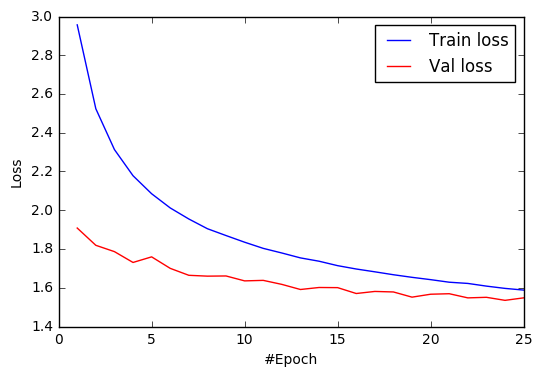

In [22]:
# l2 with SGD, lr=0.001, decay learning ratae
l2_model = gen_nn(l2_reg=True, l2_coef=0.001, adam=False)
start = time.time()
%time l2_his = l2_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop],
          verbose=0, 
          shuffle=True) \

# evaluate our model
score = l2_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(l2_his, './output/fig-nn-val-l2.png')

CPU times: user 1min 48s, sys: 18.2 s, total: 2min 6s
Wall time: 2min 11s

Test loss: 1.724
Test accuracy: 0.391


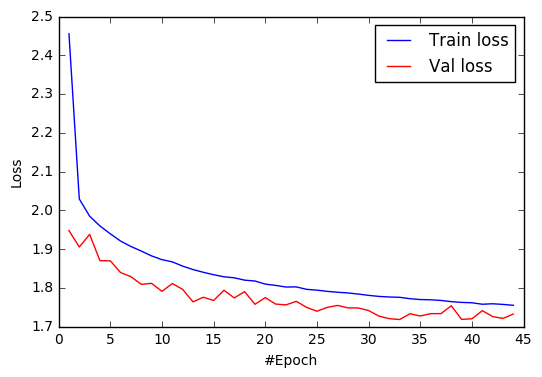

In [86]:
# l2 with adam , lr=0.001, no decay
l2_model = gen_nn(l2_reg=True, l2_coef=0.005, adam=True)
%time l2_his = l2_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = l2_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(l2_his, './output/fig-nn-val-l2.png')

CPU times: user 1min 54s, sys: 19.3 s, total: 2min 13s
Wall time: 2min 13s

Test loss: 1.720
Test accuracy: 0.389


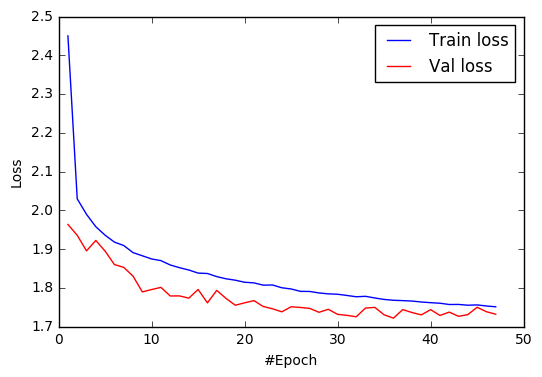

In [96]:
# l2 regularizarion with adam , lr=0.001, with decay
l2_model = gen_nn(l2_reg=True, l2_coef=0.005, adam=True)
%time l2_his = l2_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = l2_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(l2_his, './output/fig-nn-val-l2.png')

CPU times: user 1min 45s, sys: 17.3 s, total: 2min 3s
Wall time: 2min 3s

Test loss: 1.534
Test accuracy: 0.463


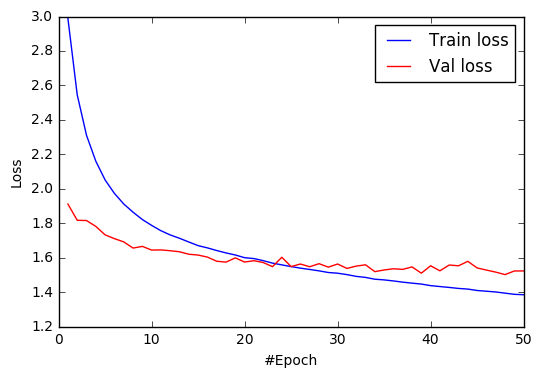

In [42]:
# l2 regularizarion with SGD and decay rate
l2_model = gen_nn(l2_reg=True, l2_coef=0.001)
start = time.time()
%time l2_his = l2_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = l2_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(l2_his, './output/fig-nn-val-l2.png')

# Weight Constraint
we can also add weight constraint to constrain the norm of weight on a layer by passing W_constraint to the layer
```
from keras.constraints import maxnorm
model.add(Dense(1024, W_constraint = maxnorm(3)))
```


CPU times: user 36.9 s, sys: 2.16 s, total: 39.1 s
Wall time: 39.1 s

Test loss: 1.666
Test accuracy: 0.427


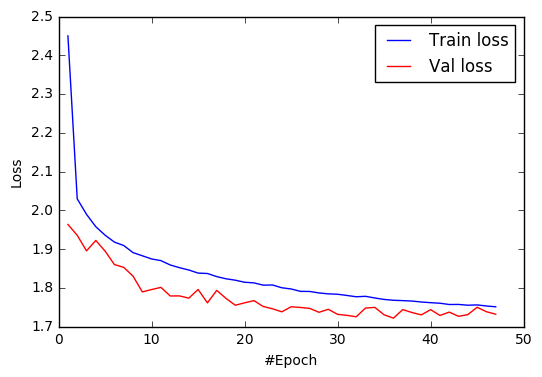

In [98]:
# weight constraint with SGD and decay learning rate
weight_constraint_model = gen_nn(weight_constraint=True, adam=False)
%time weight_constraint_his = weight_constraint_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = weight_constraint_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(l2_his, './output/fig-nn-val-weight_constraint.png')

CPU times: user 45 s, sys: 2.4 s, total: 47.4 s
Wall time: 47.3 s

Test loss: 1.680
Test accuracy: 0.431


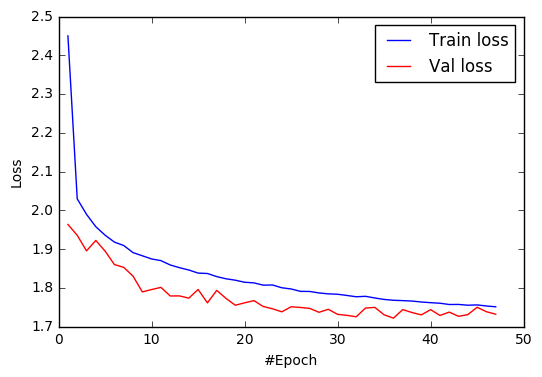

In [99]:
# weight constraint with Adam and decay learning rate
weight_constraint_model = gen_nn(weight_constraint=True, adam=True)
%time weight_constraint_his = weight_constraint_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \

# evaluate our model
score = weight_constraint_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(l2_his, './output/fig-nn-val-weight_constraint.png')

# Batch Normalization
Batch Normalization is to explicitly forcing the activations throughout a network to take on a unit gaussian distribution. The core observation is that this is possible because normalization is a simple differentiable operation. In the implementation, insert the BatchNorm layer immediately after fully connected layers and before non-linearities.

<img src="fig-batch-normalization.png" width="600">

keras have implemented Batch Normalization for you.
```
keras.layers.normalization.BatchNormalization(mode=0, axis=1, momentum=0.99, beta_init='zero', gamma_init='one')
```

- mode: integer, 0, 1 or 2.

    - 0: feature-wise normalization. Each feature map in the input will be normalized separately. The axis on which to normalize is specified by the axis argument. Note that if the input is a 4D image tensor using Theano conventions (samples, channels, rows, cols) then you should set axis to 1 to normalize along the channels axis. During training we use per-batch statistics to normalize the data, and during testing we use running averages computed during the training phase.
    - 1: sample-wise normalization. This mode assumes a 2D input.
    - 2: feature-wise normalization, like mode 0, but using per-batch statistics to normalize the data during both testing and training.
    
- axis: integer, axis along which to normalize in mode 0.




CPU times: user 50.7 s, sys: 1.78 s, total: 52.5 s
Wall time: 52.5 s

Test loss: 1.735
Test accuracy: 0.439


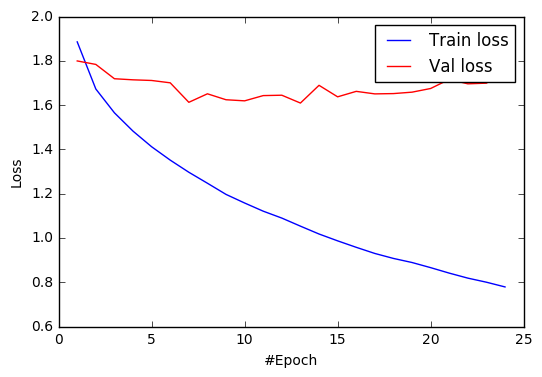

In [109]:
# batch normalization with Adam and decay learning rate
batch_norm_model = gen_nn(batch_normalization=True, adam=True, learning_rate=0.0001)
%time batch_norm_his = batch_norm_model.fit(X_train_grey, y_train, \
          batch_size=batch_size, \
          nb_epoch=nb_epoch, \
          validation_data=(X_valid_grey, y_valid), \
          callbacks=[early_stop], \
          verbose=0, \
          shuffle=True) \
# evaluate our model
score = batch_norm_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(batch_norm_his, './output/fig-nn-val-batch_norm.png')

# Noise
We can add noise to our data by data augmentation. We will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better. This skill is very useful especially when you have very little amount of data.
* rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
* width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
* shear_range is for randomly applying shearing transformations
* zoom_range is for randomly zooming inside pictures
* horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

below we visualize some images after augmentation

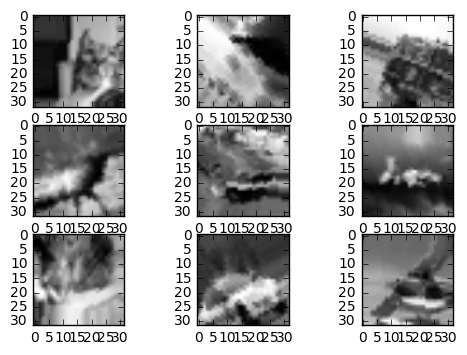

In [131]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as pyplot
datagen = ImageDataGenerator(
        rotation_range=40, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
# visualize some examples after augmentation
for X_batch, y_batch in datagen.flow(X_train_grey, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i, 0], cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break

CPU times: user 4min 4s, sys: 7.02 s, total: 4min 11s
Wall time: 3min 48s

Test loss: 1.745
Test accuracy: 0.380


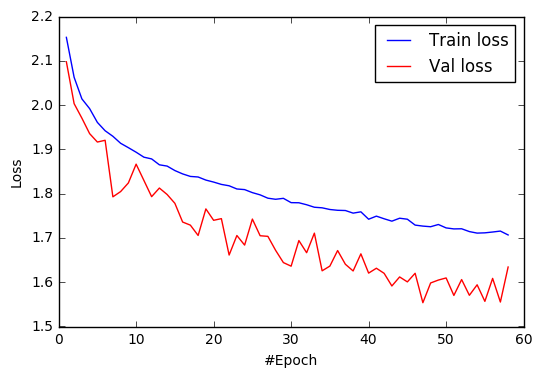

In [119]:
nb_epoch = 50
# data augmentation with SGD and decay learning rate
batch_model = gen_nn(adam=True, decay=False)
start = time.time()
%time aug_his = batch_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train_grey.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_base_norm_his, './output/fig-nn-val-aug.png')

CPU times: user 5min 13s, sys: 9.14 s, total: 5min 22s
Wall time: 4min 53s

Test loss: 1.745
Test accuracy: 0.380


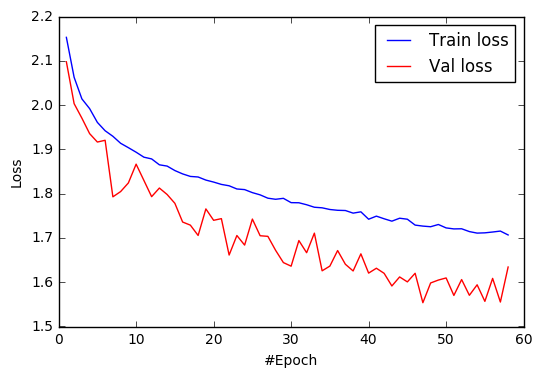

In [120]:
nb_epoch = 50
# data augmentation with SGD and decay learning rate
batch_model = gen_nn(adam=True)
start = time.time()
%time aug_his = batch_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train_grey.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_base_norm_his, './output/fig-nn-val-aug.png')

CPU times: user 5min 7s, sys: 9.22 s, total: 5min 16s
Wall time: 4min 47s

Test loss: 1.672
Test accuracy: 0.407


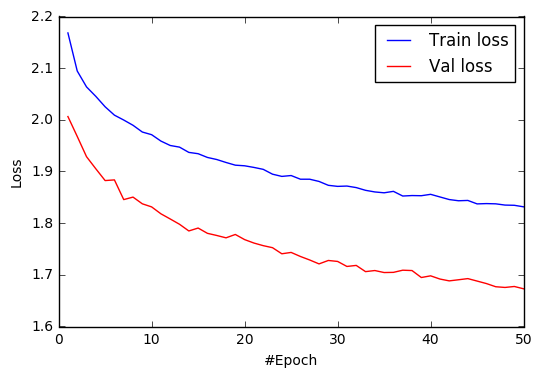

In [124]:
# data augmentation with SGD and decay learning rate. data generator: 40 0.2 0.2 0.2 0.2
base_model = gen_nn()    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

CPU times: user 5min 9s, sys: 9.31 s, total: 5min 18s
Wall time: 4min 50s

Test loss: 1.611
Test accuracy: 0.435


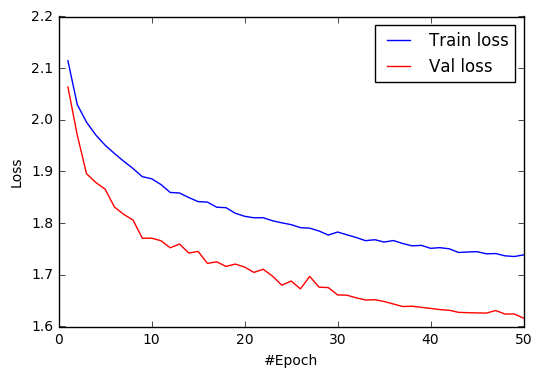

In [129]:
# data augmentation with SGD and decay learning rate. data generator: 40 0.1 0.1 0.2 0.2
base_model = gen_nn()    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

In [ ]:
# data augmentation with SGD and decay learning rate. data generator: 20 0.1 0.1 0.2 0.2
base_model = gen_nn()    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

In [ ]:
base_model = gen_nn(adam=True, decay=False)    
start = time.time()
%time aug_his = base_model.fit_generator(datagen.flow(X_train_grey, y_train,
                    batch_size=batch_size),
                    samples_per_epoch=X_train.shape[0],
                    nb_epoch=nb_epoch,
                    callbacks=[early_stop],
                    verbose=0, 
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_his, './output/fig-nn-val-aug.png')

data generator has a significant effect here!
Now, let's try to combine the differenct methods.

# data augmentation + batch normalization

CPU times: user 3min 23s, sys: 5.97 s, total: 3min 29s
Wall time: 3min 10s

Test loss: 2.366
Test accuracy: 0.103


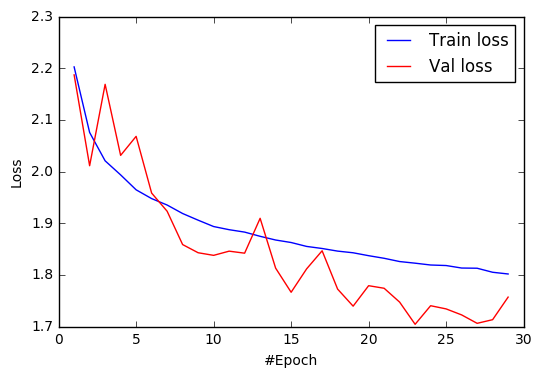

In [77]:
# BN every two layer with sgd 
batch_norm_model = gen_nn(batch_normalization=True)
start = time.time()
%time aug_base_norm_his = batch_norm_model.fit_generator(datagen.flow(X_train_grey, y_train, \
                    batch_size=batch_size), \
                    samples_per_epoch=X_train_grey.shape[0], \
                    nb_epoch=nb_epoch, \
                    callbacks=[early_stop], \
                    verbose=0, \
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_base_norm_his, './output/fig-nn-val-aug-batch_norm.png')


Training time: 195.943595 sec

Test loss: 1.706
Test accuracy: 0.387


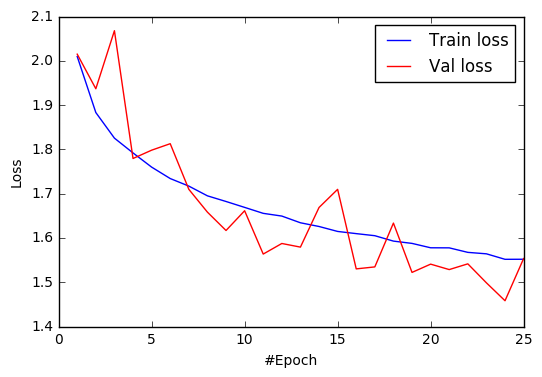

In [51]:
# BN every two layers with adam
batch_norm_model = gen_nn(batch_normalization=True, adam=True)
start = time.time()
aug_base_norm_his = batch_norm_model.fit_generator(datagen.flow(X_train_grey, y_train,
                    batch_size=batch_size),
                    samples_per_epoch=X_train_grey.shape[0],
                    nb_epoch=nb_epoch,
                    callbacks=[early_stop],
                    verbose=0, 
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_base_norm_his, './output/fig-nn-val-aug-batch_norm.png')


Training time: 288.155827 sec

Test loss: 1.611
Test accuracy: 0.435


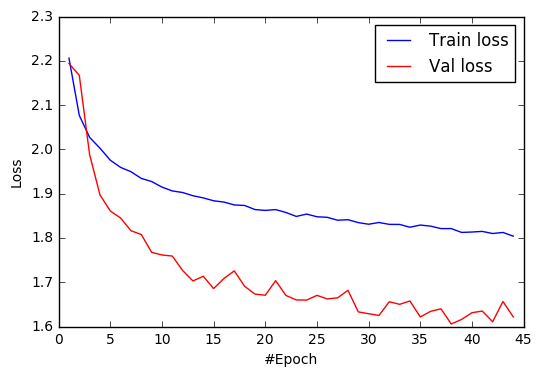

In [132]:
# BN on every layer data generator: 40 0.2 0.2 0.2 0.2
batch_norm_model = gen_nn(batch_normalization=True, adam=False)
start = time.time()
aug_base_norm_his = batch_norm_model.fit_generator(datagen.flow(X_train_grey, y_train,
                    batch_size=batch_size),
                    samples_per_epoch=X_train_grey.shape[0],
                    nb_epoch=nb_epoch,
                    callbacks=[early_stop],
                    verbose=0, 
                    validation_data=(X_valid_grey, y_valid))
# evaluate our model
score = base_model.evaluate(X_test_grey, y_test, verbose=0)
print('\nTraining time: %f sec' % float(time.time()-start))
print('\nTest loss: %.3f' % score[0])
print('Test accuracy: %.3f' % score[1])
plot_validation_history(aug_base_norm_his, './output/fig-nn-val-aug-batch_norm.png')

Now you've learned lots of techniques and layers to improve your model, good luck training!